# **A Deep Learning Approach to Predicting Product Search Relevance at Home Depot**

Based on the Kaggle link: https://www.kaggle.com/c/home-depot-product-search-relevance/data

## **Introduction**

Leveraging the power of deep learning to enhance e-commerce search functionality, this report outlines our approach to the Home Depot product search relevance prediction challenge.<br>
By employing Siamese Networks with Convolutional Neural Networks (CNNs), our method focuses on accurately pairing customer search terms with the most relevant product listings.<br>
This model aims to predict relevance scores by deeply analyzing the nuances of textual data from search terms and product descriptions.

## **Download and import of packages**

In [ ]:
# ! pip install gensim
# ! pip install neptune
# ! pip install pydot
# ! pip install graphviz
! pip install tqdm

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
import gensim
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from math import sqrt
import neptune
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.utils import plot_model

C:\Users\kathy\AppData\Local\Temp\ipykernel_53320\1749481348.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Set the device to gpu or cpu accordingly to availability.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## **Loading the data**
- train.csv and test.csv require ISO-8859-1 encoding and not default UTF-8 because of special characters.
- solutions.csv contains public/private/ignored scores, where ignored relevances are -1, we will filter those.
- Join product descriptions to train and test by product_uid.
- the work explictly says to use search_term and product_description as inputs, so we will drop product_title.<br>
though, a possible preprocess improvement would be to concatenate the title and description.

In [115]:
# Load the data
product_des = pd.read_csv('home-depot-product-search-relevance/data/product_descriptions.csv')
train = pd.read_csv('home-depot-product-search-relevance/data/train.csv', encoding='ISO-8859-1')
test = pd.read_csv('home-depot-product-search-relevance/data/test.csv', encoding='ISO-8859-1')
test_sol = pd.read_csv('home-depot-product-search-relevance/data/solution.csv')
print("Loading finished")

Loading finished


In [116]:
# Create the dataframes
train = train.drop(['product_title'], axis=1)
train = train.merge(product_des, on='product_uid', how='left')

test_sol = test_sol[test_sol['relevance']!=-1]
test_sol = test_sol.drop(['Usage'], axis=1)

test = test.drop(['product_title'], axis=1)
test = test.merge(product_des, on='product_uid', how='left')
test = test_sol.merge(test, on='id', how='left')

In [6]:
test

,id,relevance,product_uid,search_term,product_description
0,4,2.33,100001,metal l brackets,"Not only do angles make joints stronger, they ..."
1,5,2.33,100001,simpson sku able,"Not only do angles make joints stronger, they ..."
2,6,2.67,100001,simpson strong ties,"Not only do angles make joints stronger, they ..."
3,7,2.00,100001,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."
4,10,2.67,100003,bath and shower kit,Classic architecture meets contemporary design...
...,...,...,...,...,...
112062,221467,2.33,206644,roof nailing gun,The CN445R2 is the latest version of the MAX S...
112063,221468,1.00,206645,kitchen pro grout,The GROHE Ladylux 3 Pro Single-Handle Pull-Out...
112064,221469,2.67,206646,tilekit 30 x 60 wall bone,The Tile Kit bathtub wall set has a tile-like ...
112065,221470,1.00,206647,light switchvers for little girls,Your daughter will be a queen ready to cast he...


In [97]:
train

,id,product_uid,search_term,relevance,product_description
0,2,100001,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...
74062,221457,206638,tv riser glass,1.00,"Atlantic, Inc. 94835722 Uniquely designed for ..."
74063,221458,206639,r20 halogen light,3.00,Philips Energy Advantage lamps use less energy...
74064,221463,206641,schlage lock siena half dummy knob with,2.33,The Schlage Camelot In-Active Aged Bronze Hand...
74065,221471,206648,zen garden decor,3.00,The Rose Garden is inspired by the popular ear...


Extract the labels

In [117]:
labels_train = train['relevance']
labels_test = test['relevance']

labels_test

0         2.33
1         2.33
2         2.67
3         2.00
4         2.67
          ... 
112062    2.33
112063    1.00
112064    2.67
112065    1.00
112066    2.33
Name: relevance, Length: 112067, dtype: float64

## **Exploratory Data Analysis**

Data exploration is an important step towards a solution to the problem.

**Data size**

In [119]:
print('Train number of records: ' + str(train.shape[0]))
print('Test number of records: ' + str(test.shape[0]))

Train number of records: 74067
Test number of records: 112067


**Looking at samples**

In [32]:
train['search_term'].head(20)

0                          angle bracket
1                              l bracket
2                              deck over
3                       rain shower head
4                     shower only faucet
5                         convection otr
6                   microwave over stove
7                             microwaves
8                        emergency light
9                                mdf 3/4
10                          steele stake
11        briggs and stratton lawn mower
12                              gas mowe
13                           honda mower
14    hampton bay chestnut pull up shade
15                              disposer
16                          grill gazebo
17                           door guards
18                metal plate cover gcfi
19                        radiator grate
Name: search_term, dtype: object

We can see that search terms are relativly only a few words, including just characters.<br>
They contain stop words, numbers, and sizes like 3/4,inches etc.

In [33]:
train['product_description'].head(20)

0     Not only do angles make joints stronger, they ...
1     Not only do angles make joints stronger, they ...
2     BEHR Premium Textured DECKOVER is an innovativ...
3     Update your bathroom with the Delta Vero Singl...
4     Update your bathroom with the Delta Vero Singl...
5     Achieving delicious results is almost effortle...
6     Achieving delicious results is almost effortle...
7     Achieving delicious results is almost effortle...
8     The Quantum Adjustable 2-Light LED Black Emerg...
9     Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
10    Valley View Industries Metal Stakes (4-Pack) a...
11    Recycler 22 in. Personal Pace Variable Speed S...
12    Recycler 22 in. Personal Pace Variable Speed S...
13    Recycler 22 in. Personal Pace Variable Speed S...
14    The 96 in. wide Caramel Simple Weave Rollup Ba...
15    The InSinkErator SinkTop Switch Single Outlet ...
16    Make grilling great with this handsome and fun...
17    The MD Building Products 36 in. x 36 in. x

The product descriptions are complicated and a lot longer then search terms.<br>
They contain different measurnment types in different formats,some parantheses and special characters.

In [34]:
train['relevance'].value_counts()

relevance
3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.75       11
2.25       11
1.75        9
1.50        5
1.25        4
Name: count, dtype: int64

Looking at our target label, the very high imbalance is clear to see.<br>
Also, it seems like the relevance score can be treated as a classficiation problem and not regression, as there are only 13 unique labels.<br>

**Data distribution**

Check the distribution and spread of the relevance, because Relevance is our label column

<Axes: >

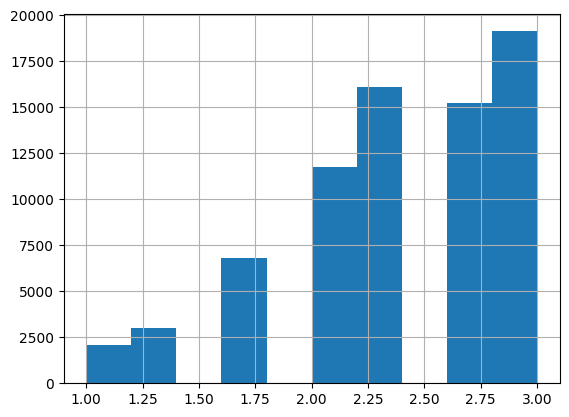

In [9]:
train.relevance.hist()

* We can see that the majority of the search relevancy are above 2.

Search query word length distribution:

<Axes: >

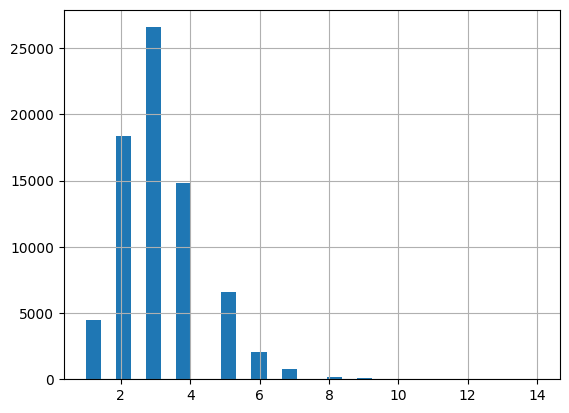

In [10]:
(train.search_term.str.count("\\s+") + 1).hist(bins=30)

How many search query there is for each product:

In [11]:
# Count the occurrences of each unique 'product_uid'
product_uid_counts = train['product_uid'].value_counts()

# Counting how many product_uid have each unique count
count_distribution_df  = product_uid_counts.reset_index()

count_distribution_df.columns = ['num_of_product_uids', 'counts']  # Naming the columns explicitly
df_counts_sorted_asc = count_distribution_df.sort_values(by='counts', ascending=False)

print(df_counts_sorted_asc)

       num_of_product_uids  counts
0                   102893      21
1                   101959      21
2                   101892      18
4                   101539      17
5                   104691      17
...                    ...     ...
26156               188925       1
26157               194924       1
26158               188926       1
26159               188927       1
54666               206650       1

[54667 rows x 2 columns]


Distribution of products by number of samples:

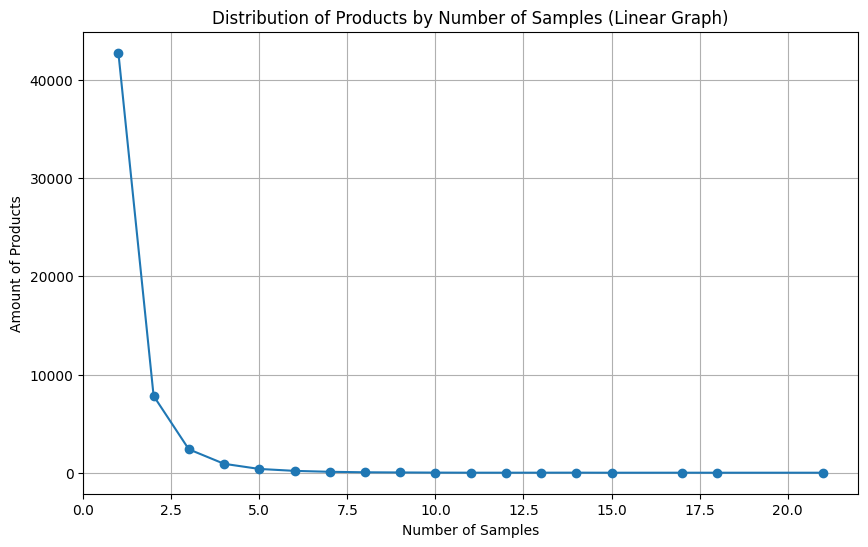

,Number of Samples,Amount of Products
0,1,42765
1,2,7824
2,3,2385
3,4,909
4,5,386
5,6,190
6,7,95
7,8,45
8,9,27
9,10,13


In [12]:
# Simulating the DataFrame from the user's print statement
df_counts_sorted_asc = pd.DataFrame(df_counts_sorted_asc)

# Counting how many product_uids have each unique 'counts' value
samples_count_distribution = df_counts_sorted_asc['counts'].value_counts().sort_index()

# Converting to DataFrame for plotting
samples_count_distribution_df = samples_count_distribution.reset_index()
samples_count_distribution_df.columns = ['Number of Samples', 'Amount of Products']

# Plotting the distribution as a linear graph instead of a bar chart
plt.figure(figsize=(10, 6))
plt.plot(samples_count_distribution_df['Number of Samples'], samples_count_distribution_df['Amount of Products'], marker='o')
plt.title('Distribution of Products by Number of Samples (Linear Graph)')
plt.xlabel('Number of Samples')
plt.ylabel('Amount of Products')
plt.grid(True)
plt.show()

samples_count_distribution_df

* We can see that for the majority of item there is only 1 search query.

Based on the distribution of product sample counts in the dataset, here are some conclusions:
1. Most products have very few samples, indicating infrequent searches.
2. A rapid decline in product counts as sample numbers increase shows that frequently searched products are rare.
3. A few products have many samples, suggesting they are significantly more popular or visible.
4. This skewness can inform targeted strategies in marketing and inventory management.

**Check missing values**

In [13]:
print("Check missing values for train:")
print(str(train.info()))

print("\n----------------------------------------------\n")

print("Check missing values for test:")
print(str(test.info()))

Check missing values for train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   74067 non-null  int64  
 1   product_uid          74067 non-null  int64  
 2   search_term          74067 non-null  object 
 3   relevance            74067 non-null  float64
 4   product_description  74067 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB
None

----------------------------------------------

Check missing values for test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112067 entries, 0 to 112066
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   112067 non-null  int64  
 1   relevance            112067 non-null  float64
 2   product_uid          112067 non-null  int64 

No missing values detected

## **Task 1 - Character level model**

### **1.a. - Preprocess the data**

**In the preprocessing stage, we'll perform the following operations:**
1. **Lowercasing**:
   Convert all text to lowercase to ensure uniformity, minimizing the impact of case variation on our analysis.
2. **Character Listification**:
   Convert the contents of 'search_term' and 'product_description' into lists of individual characters. This step breaks down text into its most granular components, preparing for detailed textual analysis.
3. **Character Conversion**:
   Transform the 'search_term' column in both training and testing datasets into sequences of ASCII values. We'll apply a lambda function to achieve this conversion, facilitating direct comparison and processing of textual data.


Here's an example to illustrate the process:
- Original: "Not only do angles"
- Lowercased: "not only do angles"
- Listified: ['n', 'o', 't', ' ', 'o', 'n', 'l', 'y', ' ', 'd', 'o', ' ', 'a', 'n', 'g', 'l', 'e', 's']
- ASCII Converted: [110, 111, 116, 32, 111, 110, 108, 121, 32, 100, 111, 32, 97, 110, 103, 108, 101, 115]

**Convert all words to lower case**

In [120]:
train_search = train['search_term'].str.lower()
train_disc = train['product_description'].str.lower()

test_search = test['search_term'].str.lower()
test_disc = test['product_description'].str.lower()

train = pd.DataFrame(
    {'search_term': train_search,
     'product_description': train_disc
    })
test = pd.DataFrame(
    {'search_term': test_search,
     'product_description': test_disc
    })

In [121]:
train.head()

,search_term,product_description
0,angle bracket,"not only do angles make joints stronger, they ..."
1,l bracket,"not only do angles make joints stronger, they ..."
2,deck over,behr premium textured deckover is an innovativ...
3,rain shower head,update your bathroom with the delta vero singl...
4,shower only faucet,update your bathroom with the delta vero singl...


In [122]:
test.head()

,search_term,product_description
0,metal l brackets,"not only do angles make joints stronger, they ..."
1,simpson sku able,"not only do angles make joints stronger, they ..."
2,simpson strong ties,"not only do angles make joints stronger, they ..."
3,simpson strong tie hcc668,"not only do angles make joints stronger, they ..."
4,bath and shower kit,classic architecture meets contemporary design...


**Convert the 'search_term' and 'product_description' columns to lists of characters**

In [123]:
# Convert 'search_term' from both train and test datasets into lists of characters
train_search = train['search_term'].apply(list)
test_search = test['search_term'].apply(list)

# Convert 'product_description' from both train and test datasets into lists of characters
train_disc = train['product_description'].apply(list)
test_disc = test['product_description'].apply(list)

# Create new DataFrames for the training and testing data now represented as lists of characters
train_processed = pd.DataFrame({'search_term': train_search,'product_description': train_disc})
test_processed = pd.DataFrame({'search_term': test_search,'product_description': test_disc})

In [124]:
train_processed.head()

,search_term,product_description
0,"[a, n, g, l, e, , b, r, a, c, k, e, t]","[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
1,"[l, , b, r, a, c, k, e, t]","[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
2,"[d, e, c, k, , o, v, e, r]","[b, e, h, r, , p, r, e, m, i, u, m, , t, e, ..."
3,"[r, a, i, n, , s, h, o, w, e, r, , h, e, a, d]","[u, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."
4,"[s, h, o, w, e, r, , o, n, l, y, , f, a, u, ...","[u, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."


In [125]:
test_processed.head()

,search_term,product_description
0,"[m, e, t, a, l, , l, , b, r, a, c, k, e, t, s]","[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
1,"[s, i, m, p, s, o, n, , s, k, u, , a, b, l, e]","[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
2,"[s, i, m, p, s, o, n, , s, t, r, o, n, g, , ...","[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
3,"[s, i, m, p, s, o, n, , s, t, r, o, n, g, , ...","[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
4,"[b, a, t, h, , a, n, d, , s, h, o, w, e, r, ...","[c, l, a, s, s, i, c, , a, r, c, h, i, t, e, ..."


**Convert 'search_term' from both the processed training and testing datasets into arrays of ASCII values using a lambda function**

In [126]:
# The ASCII value of each character is obtained with the ord() function
train_search = train_processed['search_term'].apply(lambda x: np.array([ord(i) for i in x]))
test_search = test_processed['search_term'].apply(lambda x: np.array([ord(i) for i in x]))

# Convert 'product_description' from both the processed training and testing datasets into arrays of ASCII values.
train_disc = train_processed['product_description'].apply(lambda x: np.array([ord(i) for i in x]))
test_disc = test_processed['product_description'].apply(lambda x: np.array([ord(i) for i in x]))

# Create new DataFrames that include the ASCII representations of 'search_term' and 'product_description'
train_process_ascii = pd.DataFrame({'search_term': train_search, 'product_description': train_disc})
test_process_ascii = pd.DataFrame({'search_term': test_search, 'product_description': test_disc})

In [127]:
train_process_ascii.head()

,search_term,product_description
0,"[97, 110, 103, 108, 101, 32, 98, 114, 97, 99, ...","[110, 111, 116, 32, 111, 110, 108, 121, 32, 10..."
1,"[108, 32, 98, 114, 97, 99, 107, 101, 116]","[110, 111, 116, 32, 111, 110, 108, 121, 32, 10..."
2,"[100, 101, 99, 107, 32, 111, 118, 101, 114]","[98, 101, 104, 114, 32, 112, 114, 101, 109, 10..."
3,"[114, 97, 105, 110, 32, 115, 104, 111, 119, 10...","[117, 112, 100, 97, 116, 101, 32, 121, 111, 11..."
4,"[115, 104, 111, 119, 101, 114, 32, 111, 110, 1...","[117, 112, 100, 97, 116, 101, 32, 121, 111, 11..."


In [128]:
test_process_ascii.head()

,search_term,product_description
0,"[109, 101, 116, 97, 108, 32, 108, 32, 98, 114,...","[110, 111, 116, 32, 111, 110, 108, 121, 32, 10..."
1,"[115, 105, 109, 112, 115, 111, 110, 32, 115, 1...","[110, 111, 116, 32, 111, 110, 108, 121, 32, 10..."
2,"[115, 105, 109, 112, 115, 111, 110, 32, 115, 1...","[110, 111, 116, 32, 111, 110, 108, 121, 32, 10..."
3,"[115, 105, 109, 112, 115, 111, 110, 32, 115, 1...","[110, 111, 116, 32, 111, 110, 108, 121, 32, 10..."
4,"[98, 97, 116, 104, 32, 97, 110, 100, 32, 115, ...","[99, 108, 97, 115, 115, 105, 99, 32, 97, 114, ..."


**Find the lengths of 'search_term' and 'product_description' in a DataFrame**

In [129]:
def calculate_min_max_average(list_one, list_two):
    min_length = float('inf')  # Initialize with infinity
    max_length = -float('inf')  # Initialize with negative infinity
    total_length = 0
    total_count = 0  # Keep track of the total number of items

    # Function to update min, max, and sum based on item type
    def update_stats(item):
        nonlocal min_length, max_length, total_length
        if isinstance(item, (list, str)):  # Check if item is a list or a string
            length = len(item)
        elif isinstance(item, (int, float)):  # Check if item is a number
            length = item  # Treat the number as its own length
        else:
            return  # Skip items that are neither list, string, nor number

        total_length += length
        if length < min_length:
            min_length = length
        if length > max_length:
            max_length = length

    # Iterate through both lists, updating stats
    for item in list_one:
        update_stats(item)
        total_count += 1  # Increment total count for each processed item
    for item in list_two:
        update_stats(item)
        total_count += 1

    if total_count == 0:  # Prevent division by zero
        return 0, 0, 0
    if min_length == float('inf'):  # If min_length was never updated
        min_length = 0
    if max_length == -float('inf'):  # If max_length was never updated
        max_length = 0

    average_length = total_length // total_count  # Calculate average

    return min_length, max_length, average_length

In [130]:
search_term_min, search_term_max, search_term_avg = calculate_min_max_average(train['search_term'],test['search_term'])
prod_des_min, prod_des_max, prod_des_avg = calculate_min_max_average(train['product_description'],test['product_description'])
print(f"Seach Term : min-{search_term_min}, max-{search_term_max}, avg-{search_term_avg}")
print(f"Product Description : min-{prod_des_min}, max-{prod_des_max}, avg-{prod_des_avg}")

Seach Term : min-1, max-60, avg-18
Product Description : min-8, max-5516, avg-888


We can see the ranges between search term and product descriptions are very large, we will choose to pad to the average because of memory efficency

In [131]:
def pad_seq(df,pad_len):
    df['search_term'] = [x for x in pad_sequences(df['search_term'], maxlen=pad_len, padding='post')]
    df['product_description'] = [x for x in pad_sequences(df['product_description'], maxlen=pad_len, padding='post')]
    return df

max_pad_size = prod_des_avg if prod_des_avg > search_term_avg else search_term_avg

print(f"max_pad_size: {max_pad_size}")
train_pad = pad_seq(train_process_ascii, max_pad_size)
test_pad = pad_seq(test_process_ascii, max_pad_size)

max_pad_size: 888


### **1.b. - Siamese network model**

**Splitting the dataset into training and validation sets**

In [140]:
# Splitting the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(train_pad,labels_train.values, test_size=0.2, stratify=labels_train, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(train_pad,labels_train.values, test_size=0.2, random_state=42)


X_test = test_pad
y_test = labels_test

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

X_train: (59253, 2), X_val: (14814, 2), X_test: (112067, 2)
y_train: (59253,), y_val: (14814,), y_test: (112067,)


In [133]:
def get_dataset_dataloader(x,y,batch_size=32,shuffle=False):
    X_search_np = np.array(x['search_term'].values.tolist()).astype(np.int64)
    X_desc_np = np.array(x['product_description'].values.tolist()).astype(np.int64)
    y_np = np.array(y, dtype=np.float32)

    X_search_tensor = torch.tensor(X_search_np, dtype=torch.long)
    X_desc_tensor = torch.tensor(X_desc_np, dtype=torch.long)
    y_tensor = torch.tensor(y_np, dtype=torch.float32)

    dataset = TensorDataset(X_search_tensor, X_desc_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset,dataloader

**The Siamese network model**

The `SiameseNetwork` architecture is designed for tasks that involve comparing two inputs, like verifying if two sentences are similar. It uses a shared network to process both inputs, ensuring that the same transformation is applied, making the comparison meaningful.

- **Embedding Layer**: Converts input vocab indices into dense vectors of a specified size (`embedding_dim`), facilitating the model to learn representations for each word.

- **Convolutional Layers**: Two convolutional layers (`conv1` and `conv2`) process the embedded input. These layers help the model to extract local features from the input sequence.

- **Pooling Layers**: Following each convolutional layer, a max-pooling operation reduces the dimensionality of the data, focusing on the most significant features and reducing computation for subsequent layers.

- **Flattening**: The output from the last pooling layer is flattened into a single vector, making it suitable for processing by fully connected layers.

- **Fully Connected Layer**: The flattened vector is passed through a fully connected layer (`fc`) to map the extracted features to a single value representing the similarity between the two inputs.

- **Forward Pass**: The `forward_once` method processes each input through the embedding, convolutional, pooling, and flattening steps. The `forward` method calls `forward_once` for each of the two inputs, then calculates their similarity by taking the absolute difference of their outputs from `forward_once` and passing it through the fully connected layer.

This architecture is effective for learning complex patterns and relationships between pairs of inputs, making it suitable for tasks like semantic similarity.

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, vocab_size, embedding_dim, channels, max_pad_size):
        super(SiameseNetwork, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=channels[0], kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=channels[0], out_channels=channels[1], kernel_size=3, padding=1)
        
        # Dynamically calculate the flattened size after conv and pool layers
        self.max_pad_size = max_pad_size
        dummy_input = torch.zeros((1, max_pad_size), dtype=torch.long)
        dummy_output = self.forward_once(dummy_input)
        self.flattened_size = dummy_output.shape[1]
        
        # Fully connected layer
        self.fc = nn.Linear(self.flattened_size, 1)
        
    def forward_once(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Rearrange for Conv1d
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        # Concatenate the outputs for final similarity measurement
        combined_output = torch.abs(output1 - output2)
        similarity = self.fc(combined_output)
        return similarity

Initialization Dataset

In [144]:
class SiameseDataset(Dataset):
    def __init__(self, search_terms, descriptions, labels=None):
        self.search_terms = search_terms
        self.descriptions = descriptions
        self.labels = labels if labels is not None else [-1] * len(search_terms)
    
    def __len__(self):
        return len(self.search_terms)
    
    def __getitem__(self, idx):
        search_term = self.search_terms[idx]
        description = self.descriptions[idx]
        label = self.labels[idx]
        return search_term, description, label

def get_dataset_dataloader(x, y=None, batch_size=32, shuffle=False):
    # Convert the sequences of ASCII values into tensors
    X_search_tensor = torch.tensor(x['search_term'].tolist(), dtype=torch.long)
    X_desc_tensor = torch.tensor(x['product_description'].tolist(), dtype=torch.long)

    if y is not None:
        y_tensor = torch.tensor(y.tolist(), dtype=torch.float32)
        dataset = TensorDataset(X_search_tensor, X_desc_tensor, y_tensor)
    else:
        # If 'y' is None, indicating no labels are available (e.g., for test set)
        dataset = TensorDataset(X_search_tensor, X_desc_tensor)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, dataloader

# Example usage with placeholder data for X_train, y_train, etc.
batch_size = 64
train_dataset, train_dataloader = get_dataset_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataset, val_dataloader = get_dataset_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset, test_dataloader = get_dataset_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)


Initialization of hyperparameters

In [145]:
vocab_size = 256
embed_dim = 50
channels = [16, 32]
model = SiameseNetwork(vocab_size=vocab_size, embedding_dim=embed_dim, channels=channels, max_pad_size=max_pad_size)
lr = 0.0001

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
num_epochs = 10

Calculate metrics

In [95]:
def calculate_metrics(model, data_loader, criterion=None):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for batch in data_loader:
            # Adjust unpacking based on the number of elements in the batch
            if len(batch) == 3:
                inputs1, inputs2, labels = batch
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            elif len(batch) == 2:
                inputs1, inputs2 = batch
                inputs1, inputs2 = inputs1.to(device), inputs2.to(device)
                labels = None
            
            outputs = model(inputs1, inputs2)
            if labels is not None and criterion is not None:
                loss = criterion(outputs.squeeze(), labels)
                total_loss += loss.item()
                all_labels.extend(labels.cpu().numpy())
            
            all_outputs.extend(outputs.squeeze().cpu().numpy())

        # Calculate metrics only if labels were provided
        if all_labels:
            rmse = sqrt(mean_squared_error(all_labels, all_outputs))
            mae = mean_absolute_error(all_labels, all_outputs)
            avg_loss = total_loss / len(data_loader)
        else:
            rmse = mae = avg_loss = None  # Set to None if no labels are present

    return avg_loss, rmse, mae

In [146]:
# Initialize Neptune run
run = neptune.init_run(
    project="rovo/dl-workshop-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ODM2YmQ5ZC1mOGNkLTQyNGEtOTA1NC1jZjZmOWUxOTVmOTMifQ==",
)

# Define model parameters for logging
params = {
    "model_type": "char",
    "epochs": num_epochs,
    "max_pad_size": max_pad_size,
    "batch_size": batch_size,
    "embed_dim": embed_dim,
    "channels": f"{channels[0]},{channels[1]}",
    "learning_rate": lr,
    "optimizer": "Adam",
    "criterion": "MSE"
}
run["parameters"] = params

# Start the training loop with metrics calculation
start_time = time.time()

for epoch in tqdm(range(num_epochs)):
    model.train()
    for search, description, labels in train_dataloader:
        search, description, labels = search.to(device), description.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(search, description)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    # Calculate metrics on training and validation datasets
    train_loss, train_rmse, train_mae = calculate_metrics(model, train_dataloader, criterion)
    # Log metrics to Neptune
    run["train/loss"].append(train_loss)
    run["train/RMSE"].append(train_rmse)
    run["train/MAE"].append(train_mae)

    val_loss, val_rmse, val_mae = calculate_metrics(model, val_dataloader, criterion)
    # Log metrics to Neptune
    run["val/loss"].append(val_loss)
    run["val/RMSE"].append(val_rmse)
    run["val/MAE"].append(val_mae)

    # Print epoch metrics
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

# Calculate metrics on the test set
test_loss, test_rmse, test_mae = calculate_metrics(model, test_dataloader, criterion)
# Log metrics to Neptune
run["test/loss"].append(test_loss)
run["test/RMSE"].append(test_rmse)
run["test/MAE"].append(test_mae)
print(f'Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')


# Calculate and log the total runtime
total_runtime = time.time() - start_time
print(f'Total training and evaluation time: {total_runtime:.2f} seconds')
run["train/time"].append(total_runtime)

# Stop the Neptune run
run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/rovo/dl-workshop-3/e/DLWOR-168


 10%|█         | 1/10 [01:49<16:25, 109.45s/it]

Epoch 1, Train Loss: 0.2847, Train RMSE: 0.5336, Train MAE: 0.4346, Val Loss: 0.2866, Val RMSE: 0.5354, Val MAE: 0.4345


 20%|██        | 2/10 [03:31<14:02, 105.27s/it]

Epoch 2, Train Loss: 0.2736, Train RMSE: 0.5231, Train MAE: 0.4310, Val Loss: 0.2814, Val RMSE: 0.5305, Val MAE: 0.4363


 30%|███       | 3/10 [05:13<12:04, 103.52s/it]

Epoch 3, Train Loss: 0.2658, Train RMSE: 0.5155, Train MAE: 0.4232, Val Loss: 0.2792, Val RMSE: 0.5284, Val MAE: 0.4327


 40%|████      | 4/10 [06:51<10:08, 101.43s/it]

Epoch 4, Train Loss: 0.2605, Train RMSE: 0.5103, Train MAE: 0.4177, Val Loss: 0.2788, Val RMSE: 0.5281, Val MAE: 0.4318


 50%|█████     | 5/10 [08:36<08:32, 102.60s/it]

Epoch 5, Train Loss: 0.2565, Train RMSE: 0.5064, Train MAE: 0.4124, Val Loss: 0.2797, Val RMSE: 0.5289, Val MAE: 0.4302


 60%|██████    | 6/10 [10:16<06:47, 101.77s/it]

Epoch 6, Train Loss: 0.2516, Train RMSE: 0.5016, Train MAE: 0.4113, Val Loss: 0.2797, Val RMSE: 0.5289, Val MAE: 0.4333


 70%|███████   | 7/10 [11:58<05:05, 101.89s/it]

Epoch 7, Train Loss: 0.2490, Train RMSE: 0.4990, Train MAE: 0.4051, Val Loss: 0.2820, Val RMSE: 0.5311, Val MAE: 0.4308


 80%|████████  | 8/10 [13:42<03:25, 102.73s/it]

Epoch 8, Train Loss: 0.2463, Train RMSE: 0.4963, Train MAE: 0.4019, Val Loss: 0.2834, Val RMSE: 0.5324, Val MAE: 0.4312


 90%|█████████ | 9/10 [15:22<01:41, 101.69s/it]

Epoch 9, Train Loss: 0.2471, Train RMSE: 0.4971, Train MAE: 0.4000, Val Loss: 0.2897, Val RMSE: 0.5382, Val MAE: 0.4329


100%|██████████| 10/10 [17:05<00:00, 102.58s/it]

Epoch 10, Train Loss: 0.2398, Train RMSE: 0.4897, Train MAE: 0.3975, Val Loss: 0.2855, Val RMSE: 0.5344, Val MAE: 0.4340


Test Loss: 0.2968, Test RMSE: 0.5447, Test MAE: 0.4423
Total training and evaluation time: 1065.87 seconds
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/rovo/dl-workshop-3/e/DLWOR-168/metadata


**The best results we got:**

In experiment EX.8, we utilized a character-level Siamese model with an Adam optimizer and a learning rate of 0.0001. We set the batch size to 128 and the maximum padding size to 888, which, along with an embedding dimension of 50 and convolutional channels set to 16 and 32, resulted in a training runtime of approximately 854 seconds. The model achieved a training RMSE of 0.515 and MAE of 0.427. On the validation set, it recorded an RMSE of 0.530 and an MAE of 0.443, while on the test set, it achieved an RMSE of 0.535 and an MAE of 0.442. These results indicate a strong and consistent performance across the board.

In the graphs below you can see the performance as the epochs progress.

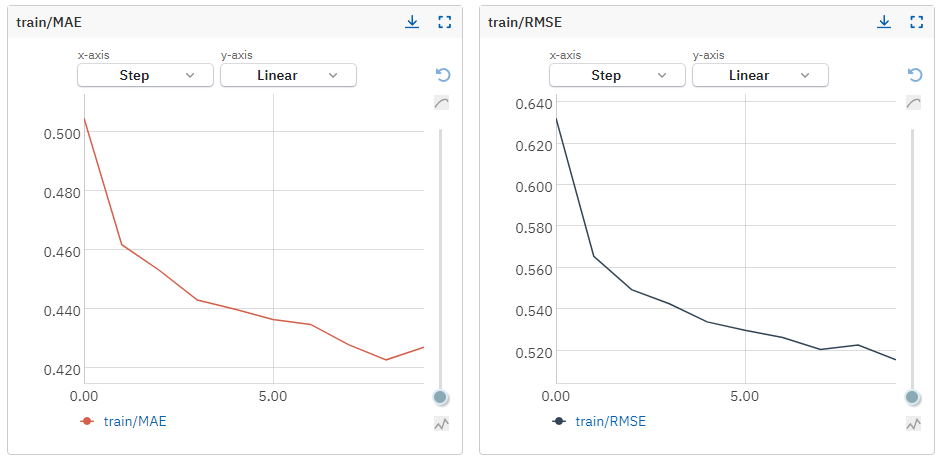

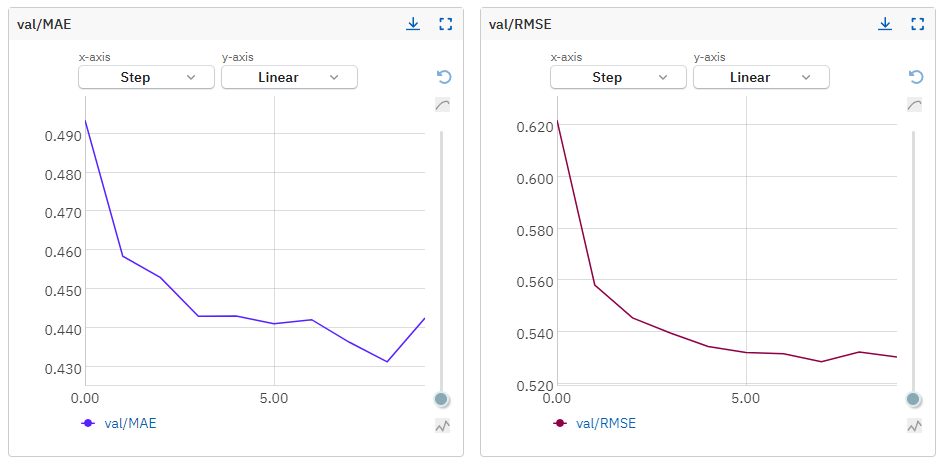

### **1.c. - Benchmark**

We use KNN model as a benchmark because it's intuitive, easy to implement, and provides a straightforward performance baseline.

We prepares text data, extracts features using character n-grams, trains a K-Nearest Neighbors (KNN) model, and evaluates it using MAE and RMSE. KNN serves as a straightforward, intuitive benchmark to gauge model performance against more complex algorithms.

In [150]:
%%time
# Prepare data
X_search_train, X_description_train, y_train = train['search_term'], train['product_description'], labels_train

# Create features using CountVectorizer
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 1))
X_features_train = np.hstack((vectorizer.fit_transform(X_search_train).toarray(), 
                        vectorizer.transform(X_description_train).toarray()))

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_features_train, y_train, test_size=0.2, random_state=42)

# Initialize and fit the model
knn_model = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

# Training metrics for comparison
y_train_pred = knn_model.predict(X_train)
train_mae, train_rmse = mean_absolute_error(y_train, y_train_pred), np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Train MAE: {train_mae}\nTrain RMSE: {train_rmse}")

# Predict and evaluate
y_val_pred = knn_model.predict(X_val)
val_mae, val_rmse = mean_absolute_error(y_val, y_val_pred), np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Val MAE: {val_mae}\nVal RMSE: {val_rmse}")

Train MAE: 0.32300401104866705
Train RMSE: 0.4105804061703523
Val MAE: 0.46224314837316055
Val RMSE: 0.5815218202866603
CPU times: total: 2min 49s
Wall time: 1min 1s


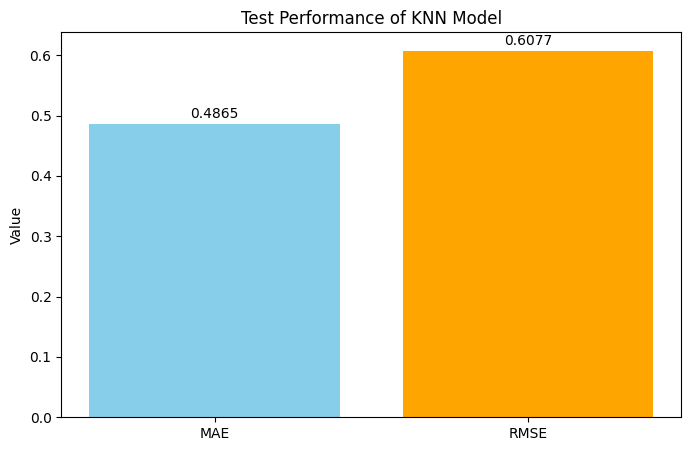

Test MAE: 0.4864649421030871
Test RMSE: 0.6076781809036642


In [153]:
X_search_test, X_description_test, y_test = test['search_term'], test['product_description'], labels_test

X_features_test = np.hstack((vectorizer.transform(X_search_test).toarray(),
                             vectorizer.transform(X_description_test).toarray()))

# Predict and evaluate on test data
y_test_pred = knn_model.predict(X_features_test)
test_mae, test_rmse = mean_absolute_error(y_test, y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred))

# Data for plotting
metrics = ['MAE', 'RMSE']
values = [test_mae, test_rmse]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'orange'])
plt.ylabel('Value')
plt.title('Test Performance of KNN Model')
plt.ylim(0, max(values) + 0.05 * max(values))  # Add some margin on top

for index, value in enumerate(values):
    plt.text(index, value + 0.01, f"{value:.4f}", ha='center')

plt.show()

print(f"Test MAE: {test_mae}\nTest RMSE: {test_rmse}")

**Our KNN benchmark model got 0.607 RMSE score**

### **Results and conclusions**

**After reviewing our experimental data, we've come to several conclusions about our character-level Siamese network models:**

- **Baseline Comparison**: Our initial baseline model, a K-Nearest Neighbors (KNN) implementation, provided us with a rudimentary understanding of the problem complexity, as evidenced by its comparatively higher loss and RMSE on both validation and test sets.

- **Learning Rate Observations**: We noticed a clear pattern in learning rate effectiveness. Models with lower learning rates, particularly 0.0001, consistently outperformed those with higher rates on RMSE and MAE metrics across validation and test sets. This trend underscores the importance of a carefully chosen learning rate to balance convergence speed and training stability.

- **Batch Size Effects**: An intriguing find was the performance of models with differing batch sizes. For instance, EX.8 with a larger batch size of 128 narrowly surpassed the model EX.6 with a batch size of 32, especially in validation loss and RMSE. This observation leads us to believe that our model may benefit from larger batch sizes, possibly due to better gradient estimation.

- **Padding and Complexity**: When we adjusted the max_pad_size to 888 (the avarage length of the sequences), we saw that models like EX.8 and EX.9 didn't just keep up but actually improved in comparison to those with the max_pad_size of 5516 (the maximal length of the sequences). This could imply that reducing input sequence length—thus reducing complexity—can be advantageous for our task without compromising performance.

- **Overall Performance**: Across the board, model EX.8 stood out with its consistent performance. It struck a fine balance between generalization and overfitting, as suggested by its training, validation, and test scores. It achieves this balance with a modest runtime, reasonable complexity, and lower validation and test RMSEs and MAEs compared to the others.

**In summary, our meticulous approach to hyperparameter tuning led us to model EX.8 as our model of choice. This model exhibits strong generalization capabilities without being prohibitively costly in terms of training time, marking a significant step forward from our initial KNN baseline.**

**Results of the experiments**

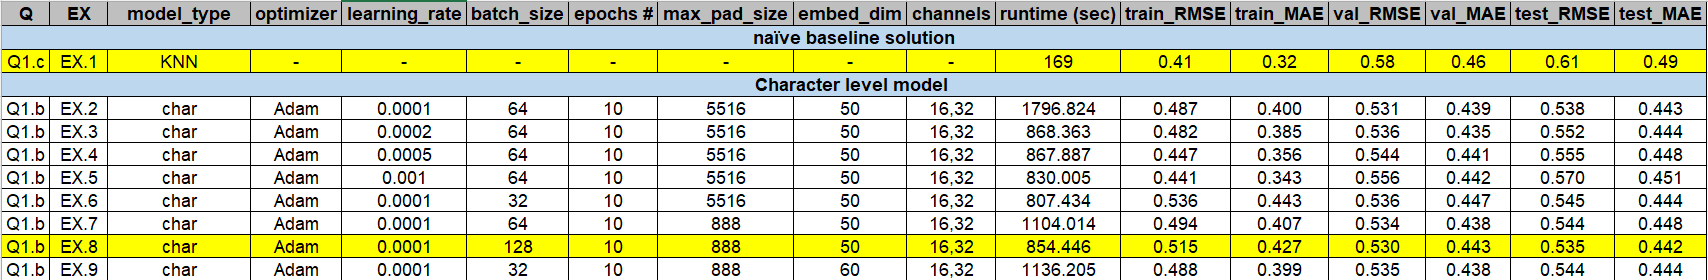

_______________________________________________________________________________________________________

## **Task 2 - Word/byte-pair embeddings and word/byte-pair level model**

### **2.a. - Word/ byte level preprocessing**

Tokenization
- removing stopwords from search terms will provide a loss of information as they are very short.
- From product descriptions we will remove stopwords.
- We will remove special characters like periods,parantheses etc.

In [ ]:
stop_words = set(stopwords.words('english'))
def get_tokens(text,remove_stopwords=False):
    text = text.lower()
    text = text.replace('.', ' ')
    text = text.replace(',', ' ')
    text = text.replace(';', ' ')
    text = text.replace(':', ' ')
    text = text.replace('&nbsp', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('"', ' ')

    tokens = text.split(' ')
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words and token != '']
    return tokens

In [ ]:
train, test = load_data()
train['search_term'] = [get_tokens(x) for x in train['search_term']]
test['search_term'] = [get_tokens(x) for x in test['search_term']]
train['product_description'] = [get_tokens(x,remove_stopwords=True) for x in train['product_description']]
test['product_description'] = [get_tokens(x,remove_stopwords=True) for x in test['product_description']]
train.head()

,id,product_uid,search_term,relevance,product_description
0,2,100001,"[angle, bracket]",3.00,"[angles, make, joints, stronger, also, provide..."
1,3,100001,"[l, bracket]",2.50,"[angles, make, joints, stronger, also, provide..."
2,9,100002,"[deck, over]",3.00,"[behr, premium, textured, deckover, innovative..."
3,16,100005,"[rain, shower, head]",2.33,"[update, bathroom, delta, vero, single-handle,..."
4,17,100005,"[shower, only, faucet]",2.67,"[update, bathroom, delta, vero, single-handle,..."


Create the vocabulary containing all the possible words

In [ ]:
def get_all_text(df):
    search_terms = df['search_term'].to_numpy()
    prod_descs = df['product_description'].to_numpy()
    return np.concatenate([search_terms,prod_descs])

train_vocab, test_vocab = load_data()
all_text = np.concatenate([get_all_text(train_vocab),get_all_text(test_vocab)])

In [ ]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(all_text)

Now that we have a vocabulary, we can convert text to sequences, each word gets a unique identifier

In [ ]:
train['search_term'] = tokenizer.texts_to_sequences(train['search_term'])
train['product_description'] = tokenizer.texts_to_sequences(train['product_description'])
test['search_term'] = tokenizer.texts_to_sequences(test['search_term'])
test['product_description'] = tokenizer.texts_to_sequences(test['product_description'])
train.head()

,id,product_uid,search_term,relevance,product_description
0,2,100001,"[769, 973]",3.00,"[2808, 192, 1391, 1993, 118, 70, 1073, 993, 10..."
1,3,100001,"[798, 973]",2.50,"[2808, 192, 1391, 1993, 118, 70, 1073, 993, 10..."
2,9,100002,"[413, 133]",3.00,"[1105, 330, 927, 9591, 896, 174, 86, 515, 892,..."
3,16,100005,"[1013, 125, 321]",2.33,"[2166, 237, 1247, 9408, 125, 230, 199, 110, 39..."
4,17,100005,"[125, 151, 230]",2.67,"[2166, 237, 1247, 9408, 125, 230, 199, 110, 39..."


The following is a helper function to calculate min max and average for the sequences

In [ ]:
def calculate_min_max_average(list_one, list_two):
    min_length = float('inf')  # Initialize with infinity
    max_length = -float('inf')  # Initialize with negative infinity
    total_length = 0
    total_count = 0  # Keep track of the total number of items

    # Function to update min, max, and sum based on item type
    def update_stats(item):
        nonlocal min_length, max_length, total_length
        if isinstance(item, (list, str)):  # Check if item is a list or a string
            length = len(item)
        elif isinstance(item, (int, float)):  # Check if item is a number
            length = item  # Treat the number as its own length
        else:
            return  # Skip items that are neither list, string, nor number

        total_length += length
        if length < min_length:
            min_length = length
        if length > max_length:
            max_length = length

    # Iterate through both lists, updating stats
    for item in list_one:
        update_stats(item)
        total_count += 1  # Increment total count for each processed item
    for item in list_two:
        update_stats(item)
        total_count += 1

    if total_count == 0:  # Prevent division by zero
        return 0, 0, 0
    if min_length == float('inf'):  # If min_length was never updated
        min_length = 0
    if max_length == -float('inf'):  # If max_length was never updated
        max_length = 0

    average_length = total_length // total_count  # Calculate average

    return min_length, max_length, average_length

In [ ]:
search_term_min, search_term_max, search_term_avg = calculate_min_max_average(train['search_term'],test['search_term'])
prod_des_min, prod_des_max, prod_des_avg = calculate_min_max_average(train['product_description'],test['product_description'])
print(f"Seach Term : min:{search_term_min}, max:{search_term_max}, avg:{search_term_avg}")
print(f"Product Description : min:{prod_des_min}, max:{prod_des_max}, avg:{prod_des_avg}")

Seach Term : min:0, max:13, avg:3
Product Description : min:1, max:565, avg:88


We can see the ranges between search term and product descriptions are very large.<br>
We will choose to pad to the average because:
- Memory efficency
- padding to the maximum length can introduce a large amount of noise into the model.
- balance between computational efficiency and retaining meaningful information from the sequences, leading to faster training and inference times without significantly compromising the model's performance.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def pad_seq(df,pad_len):
    df['search_term'] = [x for x in pad_sequences(df['search_term'], maxlen=pad_len, padding='post')]
    df['product_description'] = [x for x in pad_sequences(df['product_description'], maxlen=pad_len, padding='post')]
    return df

max_pad_size = prod_des_avg if prod_des_avg > search_term_avg else search_term_avg

print(f"max_pad_size:{max_pad_size}")
train = pad_seq(train, max_pad_size)
test = pad_seq(test, max_pad_size)

As a validation technique we will use regular split with p=0.2.<br>
The split is stratified to have a uniform distribution over the imbalanced classes.

In [ ]:
X_train = train.drop(['id','product_uid','relevance'], axis=1)
y_train = train['relevance']

X_test = test.drop(['id','product_uid','relevance'], axis=1)
y_test = test['relevance']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

X_train: (59253, 2), X_val: (14814, 2), X_test: (112067, 2)
y_train: (59253,), y_val: (14814,), y_test: (112067,)


In [ ]:
def get_dataset_dataloader(x,y,batch_size=32,shuffle=False):
    X_search_np = np.array(x['search_term'].values.tolist()).astype(np.int64)
    X_desc_np = np.array(x['product_description'].values.tolist()).astype(np.int64)
    y_np = np.array(y, dtype=np.float32)

    X_search_tensor = torch.tensor(X_search_np, dtype=torch.long)
    X_desc_tensor = torch.tensor(X_desc_np, dtype=torch.long)
    y_tensor = torch.tensor(y_np, dtype=torch.float32)

    dataset = TensorDataset(X_search_tensor, X_desc_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset,dataloader

### **2.b. - Word/byte model**

- The following model description is our base model upon which we will experiment with different hyperparameters if needed.<br>
- The preprocessing or the model code will be changed and re-runned(instead of copy/paste to new cells).<br>
- Every single change is logged using Neptune and will be presented at the next section.<br>

Architecture:
- Embedding->Conv1->MP->Conv1->MP->FC
- nn.Embedding : transform discrete input (such as indices from a vocabulary in natural language processing or categorical features in other domains) into dense vector representations.
- nn.Conv1d :  dealing with sequential data.
- nn.MaxPool1d : reduce the dimensionality of the data passing through them
- nn.Linear : After flattening a dense layer is used to map the extracted features to a new space.

Specifics:
- MSE Loss
- Dot product similarity : simple,efficent, good basis to start.
- scaling the dot product by 3 to the proper label range(1-3).

Hyperparamters:
- Epochs : 5
- max_pad_size: 88
- embedding size: 8
- Adam, learning rate: 0.001
- batch size: 32
- Convolutional channels : 16, 32

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, words_size, max_pad_size,embedding_dim, channels):
        super(SiameseNetwork, self).__init__()
        self.embedding = nn.Embedding(words_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=channels[0], kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=channels[0], out_channels=channels[1], kernel_size=3, padding=1)
        self.dense = nn.Linear(embedding_dim * max_pad_size, 64)

    def forward_once(self, x):
        """Process an input through the network's layers."""
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Rearrange the output for Conv1d: (batch_size, channels, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the dense layer
        x = F.relu(self.dense(x))
        return x

    def forward(self, input1, input2):
        """Compute the embeddings for two inputs and their similarity."""
        # Process each input through the same network
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # Compute the similarity
        similarity = torch.sum(output1 * output2, dim=1, keepdim=True)
        similarity = 3 * similarity
        return similarity

In [ ]:
def run_training(model,train_loader,val_loader,optimizer,criterion,num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_y_pred = []
        train_y_true = []

        for X_search_batch, X_des_batch, y_batch in train_loader:
            X_search_batch, X_des_batch, y_batch = X_search_batch.to(device), X_des_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_search_batch, X_des_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_search_batch.size(0)

            # Collect for metrics calculation
            train_y_pred.append(outputs.detach())
            train_y_true.append(y_batch.detach())

        # Concatenate all batches for metrics calculation
        train_y_pred = torch.cat(train_y_pred).view(-1)
        train_y_true = torch.cat(train_y_true).view(-1)

        # Calculate RMSE and MAE for training
        train_rmse = torch.sqrt(torch.mean((train_y_true - train_y_pred) ** 2))
        train_mae = torch.mean(torch.abs(train_y_true - train_y_pred))
        run["train/loss"].append(total_loss / len(train_loader.dataset))
        run["train/RMSE"].append(train_rmse.item())
        run["train/MAE"].append(train_mae.item())
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset)}, Train RMSE: {train_rmse.item()}, Train MAE: {train_mae.item()}')

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_y_pred = []
        val_y_true = []

        with torch.no_grad():
            for X_search_batch, X_des_batch, y_batch in val_loader:
                X_search_batch, X_des_batch, y_batch = X_search_batch.to(device), X_des_batch.to(device), y_batch.to(device)
                outputs = model(X_search_batch, X_des_batch)
                val_loss = criterion(outputs, y_batch.unsqueeze(1))
                total_val_loss += val_loss.item() * X_search_batch.size(0)

                # Collect for metrics calculation
                val_y_pred.append(outputs.detach())
                val_y_true.append(y_batch.detach())

        # Concatenate all batches for metrics calculation
        val_y_pred = torch.cat(val_y_pred).view(-1)
        val_y_true = torch.cat(val_y_true).view(-1)

        # Calculate RMSE and MAE for validation
        val_rmse = torch.sqrt(torch.mean((val_y_true - val_y_pred) ** 2))
        val_mae = torch.mean(torch.abs(val_y_true - val_y_pred))
        run["val/loss"].append(total_val_loss / len(val_loader.dataset))
        run["val/RMSE"].append(val_rmse.item())
        run["val/MAE"].append(val_mae.item())
        print(f'Validation Loss: {total_val_loss / len(val_loader.dataset)}, Val RMSE: {val_rmse.item()}, Val MAE: {val_mae.item()}\n')

In [ ]:
def run_test(model,test_loader,criterion):
    model.eval()
    total_test_loss = 0
    test_y_pred = []
    test_y_true = []

    with torch.no_grad():
        for X_search_batch, X_des_batch, y_batch in test_loader:
            X_search_batch, X_des_batch, y_batch = X_search_batch.to(device), X_des_batch.to(device), y_batch.to(device)
            outputs = model(X_search_batch, X_des_batch)
            test_loss = criterion(outputs, y_batch.unsqueeze(1))
            total_test_loss += test_loss.item() * X_search_batch.size(0)

            # Collect for metrics calculation
            test_y_pred.append(outputs.detach())
            test_y_true.append(y_batch.detach())

    # Concatenate all batches for metrics calculation
    test_y_pred = torch.cat(test_y_pred).view(-1)
    test_y_true = torch.cat(test_y_true).view(-1)

    # Calculate RMSE and MAE for test
    test_rmse = torch.sqrt(torch.mean((test_y_true - test_y_pred) ** 2))
    test_mae = torch.mean(torch.abs(test_y_true - test_y_pred))
    run["test/loss"].append(total_test_loss / len(test_loader.dataset))
    run["test/RMSE"].append(test_rmse.item())
    run["test/MAE"].append(test_mae.item())
    print(f'Test Loss: {total_test_loss / len(test_loader.dataset)}, test RMSE: {test_rmse.item()}, test MAE: {test_mae.item()}\n')

In [ ]:
# define hyperparameters
word_size = len(tokenizer.word_index) + 1
embed_dim = 8
criterion = nn.MSELoss()
lr=0.0001
batch_size = 64
num_epochs = 10
channels = [16,32]

In [ ]:
train_dataset, train_dataloader = get_dataset_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataset, val_dataloader = get_dataset_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset, test_dataloader = get_dataset_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

In [ ]:
import neptune
import time

run = neptune.init_run(
    project="rovo/dl-workshop-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ODM2YmQ5ZC1mOGNkLTQyNGEtOTA1NC1jZjZmOWUxOTVmOTMifQ==",
)

params = {"model_type": "word/byte","epochs":num_epochs,"max_pad_size":max_pad_size,"batch_size": batch_size ,"embed_dim": embed_dim,"channels":str(channels[0])+","+str(channels[1]) ,"learning_rate": lr, "optimizer": "Adam", "criterion": "MSE"}
run["parameters"] = params


model = SiameseNetwork(word_size,max_pad_size,embed_dim, channels).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

start_time = time.time()
run_training(model,train_dataloader,val_dataloader,optimizer,criterion, num_epochs)
train_time = time.time() - start_time
run["train/time"].append(train_time)

run_test(model,test_dataloader,criterion)
run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/rovo/dl-workshop-3/e/DLWOR-58
Epoch 1, Loss: 0.3151697922235376, Train RMSE: 0.5613998174667358, Train MAE: 0.4604223370552063
Validation Loss: 0.29936882661183034, Val RMSE: 0.5471460819244385, Val MAE: 0.4486728012561798

Epoch 2, Loss: 0.29755274100009754, Train RMSE: 0.5454839468002319, Train MAE: 0.4471855163574219
Validation Loss: 0.2953633639241771, Val RMSE: 0.5434734225273132, Val MAE: 0.45063477754592896

Epoch 3, Loss: 0.29088201265438657, Train RMSE: 0.539334774017334, Train MAE: 0.44216927886009216
Validation Loss: 0.2991571210931312, Val RMSE: 0.5469525456428528, Val MAE: 0.44146421551704407

Epoch 4, Loss: 0.28719562564757584, Train RMSE: 0.5359063744544983, Train MAE: 0.43931469321250916
Validation Loss: 0.2874848662125078, Val RMSE: 0.5361761450767517, Val MAE: 0.4415002167224884

Epoch 5, Loss: 0.28275581488514273, Train RMSE: 0.5317478775978088, Train MAE: 0.4355553686618805
Validation L

**The best results we got:**

In experiment EX.14, we employed a word/byte-pair level Siamese model optimized by Adam with a learning rate of 0.0001. A batch size of 64 and a padding size capped at 128 were chosen to strike a balance between computational demand and input detail retention. Our architecture, set with an embedding dimension of 50 and convolutional channels of 16 and 32, resulted in a runtime of roughly 49.9 seconds. Performance metrics were commendable with a train RMSE of 0.517 and MAE of 0.423. For validation, the model achieved an RMSE of 0.533 and an MAE of 0.436, while the test set saw an RMSE of 0.539 and an MAE of 0.442, indicating consistent and reliable predictions across training and unseen data.

In the graphs below you can see the performance as the epochs progress.

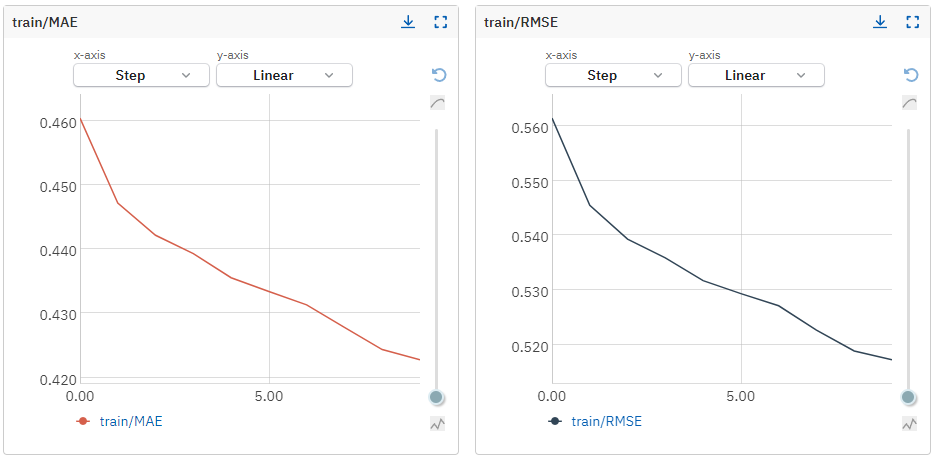
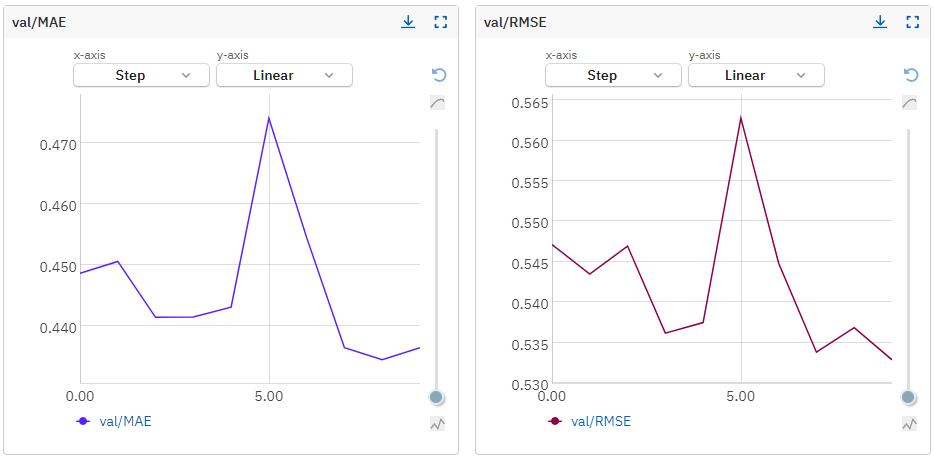

### **Results and conclusions**

**Insights from Word/Byte-Pair Embedding Experiments:**

- **Learning Rate Insights**: Lower learning rates (0.0001) were pivotal in enhancing model accuracy, as shown by the reduced RMSE and MAE values across the board, signifying the advantage of cautious learning steps.

- **Batch Size and Epochs**: Experiment EX.14, with a batch size of 64 over 10 epochs, demonstrated the effectiveness of moderate batch sizes coupled with a sufficient number of epochs to optimize the model without overfitting.

- **Padding Adjustments**: Altering the padding size to 128 in EX.14 suggested an improved trade-off between capturing sufficient sequence context and computational efficiency, achieving comparable accuracy while curtailing the runtime.

- **Stability and Overfitting**: Stability in performance metrics, despite various adjustments, indicated a need for further methods to mitigate overfitting, as observed from volatile validation losses.

**Final Considerations:**
EX.14 emerged as the standout configuration, balancing training efficiency with predictive accuracy. This model's architecture, combined with optimized hyperparameters, presents a solid foundation for future exploration, potentially involving early stopping, advanced regularization, and alternate neural architectures like LSTM to further enhance performance. It embodies a significant advancement over the baseline, emphasizing our commitment to evolve our understanding of the dataset and model intricacies.

**Results of the experiments**

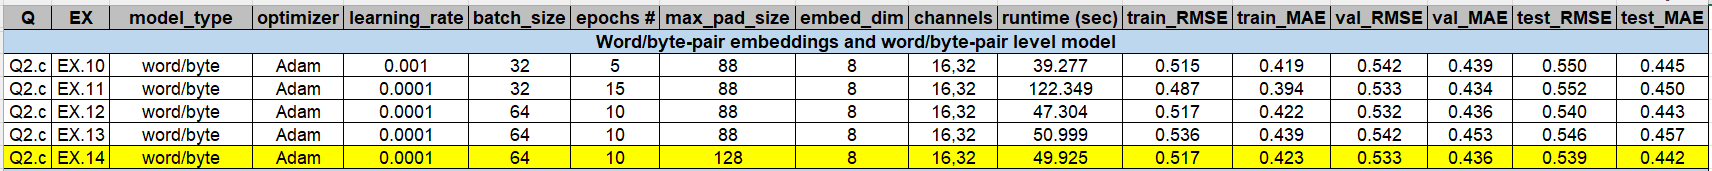

**Possible improvements:**

- Neither of the experiments proved helpful, providing a signifcant way to combat the overfitting.
- Other ways to explore can be:
    - using data augmentations like masking
    - play more with the padding sizes, or different techniques
    - other regularization techniques like l2
    - instead of learning the embedding ourselves, use word2vec or something similar.
    - early stopping, because the validation seems to be very volatile.
    - change of architecture, for example trying LSTM instead of CNN.
    - Different validation technique, seems like k-fold would be more usefull here.
    - Different criterion and similarity measures.

### **2.d. - Word/byte - Final Model & BERT Embedding(Bonus section)**
We will use the final model described in the previous section.

BERT:
- Bert requires specific tokenization so we cannot use what we used.
- We will keep padding max length at 128.

Specifics:
- Same validation technique(split p=0.2)
- Bert provides embeddings of size 768, so input in the network must be changed accordingly.
- There's no need for the embedding layer since we use BERT.


In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

def extract_embeddings(texts):
    # Tokenize and prepare for BERT
    encoded_batch = tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

    # Extract embeddings
    with torch.no_grad():
        outputs = model(**encoded_batch)
        embeddings = outputs.pooler_output

    return embeddings.cpu()


In [ ]:
from tqdm import tqdm

def get_bert_embeddings(df, batch_size):
    search_term_embeddings = []
    product_description_embeddings = []

    # Prepare tqdm to show the progress over the total number of batches
    total_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)
    progress_bar = tqdm(range(total_batches), desc='Processing')

    for i in progress_bar:
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        # Process search terms
        batch_texts = df['search_term'].iloc[start_idx:end_idx].tolist()
        embeddings = extract_embeddings(batch_texts)
        search_term_embeddings.append(embeddings)

        # Process product descriptions
        batch_texts = df['product_description'].iloc[start_idx:end_idx].tolist()
        embeddings = extract_embeddings(batch_texts)
        product_description_embeddings.append(embeddings)

    # Concatenate all batched embeddings
    search_term_embeddings = torch.cat(search_term_embeddings, dim=0)
    product_description_embeddings = torch.cat(product_description_embeddings, dim=0)

    return search_term_embeddings, product_description_embeddings

In [ ]:
batch_size = 64
train_bert,test_bert = load_data()

train_search_term_embeddings, train_product_description_embeddings = get_bert_embeddings(train_bert,batch_size)
test_search_term_embeddings, test_product_description_embeddings = get_bert_embeddings(test_bert,batch_size)

Processing: 100%|██████████| 1752/1752 [19:14<00:00,  1.52it/s]


In [ ]:
from sklearn.model_selection import train_test_split

labels = torch.tensor(train_bert['relevance'].values).float()

# Split the embeddings and labels into training and validation sets
search_term_train, search_term_val, product_description_train, product_description_val, labels_train, labels_val = train_test_split(
    train_search_term_embeddings, train_product_description_embeddings, labels, test_size=0.2, random_state=42)


 Training and Test loops are the same as previous section, copy pasted for comfort.

In [ ]:
def run_training(model,train_loader,val_loader,optimizer,criterion,num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_y_pred = []
        train_y_true = []

        for X_search_batch, X_des_batch, y_batch in train_loader:
            X_search_batch, X_des_batch, y_batch = X_search_batch.to(device), X_des_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_search_batch, X_des_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_search_batch.size(0)

            # Collect for metrics calculation
            train_y_pred.append(outputs.detach())
            train_y_true.append(y_batch.detach())

        # Concatenate all batches for metrics calculation
        train_y_pred = torch.cat(train_y_pred).view(-1)
        train_y_true = torch.cat(train_y_true).view(-1)

        # Calculate RMSE and MAE for training
        train_rmse = torch.sqrt(torch.mean((train_y_true - train_y_pred) ** 2))
        train_mae = torch.mean(torch.abs(train_y_true - train_y_pred))
        run["train/loss"].append(total_loss / len(train_loader.dataset))
        run["train/RMSE"].append(train_rmse.item())
        run["train/MAE"].append(train_mae.item())
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset)}, Train RMSE: {train_rmse.item()}, Train MAE: {train_mae.item()}')

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_y_pred = []
        val_y_true = []

        with torch.no_grad():
            for X_search_batch, X_des_batch, y_batch in val_loader:
                X_search_batch, X_des_batch, y_batch = X_search_batch.to(device), X_des_batch.to(device), y_batch.to(device)
                outputs = model(X_search_batch, X_des_batch)
                val_loss = criterion(outputs, y_batch.unsqueeze(1))
                total_val_loss += val_loss.item() * X_search_batch.size(0)

                # Collect for metrics calculation
                val_y_pred.append(outputs.detach())
                val_y_true.append(y_batch.detach())

        # Concatenate all batches for metrics calculation
        val_y_pred = torch.cat(val_y_pred).view(-1)
        val_y_true = torch.cat(val_y_true).view(-1)

        # Calculate RMSE and MAE for validation
        val_rmse = torch.sqrt(torch.mean((val_y_true - val_y_pred) ** 2))
        val_mae = torch.mean(torch.abs(val_y_true - val_y_pred))
        run["val/loss"].append(total_val_loss / len(val_loader.dataset))
        run["val/RMSE"].append(val_rmse.item())
        run["val/MAE"].append(val_mae.item())
        print(f'Validation Loss: {total_val_loss / len(val_loader.dataset)}, Val RMSE: {val_rmse.item()}, Val MAE: {val_mae.item()}\n')

In [ ]:
def run_test(model,test_loader,criterion):
    model.eval()
    total_test_loss = 0
    test_y_pred = []
    test_y_true = []

    with torch.no_grad():
        for X_search_batch, X_des_batch, y_batch in test_loader:
            X_search_batch, X_des_batch, y_batch = X_search_batch.to(device), X_des_batch.to(device), y_batch.to(device)
            outputs = model(X_search_batch, X_des_batch)
            test_loss = criterion(outputs, y_batch.unsqueeze(1))
            total_test_loss += test_loss.item() * X_search_batch.size(0)

            # Collect for metrics calculation
            test_y_pred.append(outputs.detach())
            test_y_true.append(y_batch.detach())

    # Concatenate all batches for metrics calculation
    test_y_pred = torch.cat(test_y_pred).view(-1)
    test_y_true = torch.cat(test_y_true).view(-1)

    # Calculate RMSE and MAE for test
    test_rmse = torch.sqrt(torch.mean((test_y_true - test_y_pred) ** 2))
    test_mae = torch.mean(torch.abs(test_y_true - test_y_pred))
    run["test/loss"].append(total_test_loss / len(test_loader.dataset))
    run["test/RMSE"].append(test_rmse.item())
    run["test/MAE"].append(test_mae.item())
    print(f'Test Loss: {total_test_loss / len(test_loader.dataset)}, test RMSE: {test_rmse.item()}, test MAE: {test_mae.item()}\n')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetworkBERT(nn.Module):
    def __init__(self):
        super(SiameseNetworkBERT, self).__init__()
        #  BERT embeddings of size 768
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Adjust the size accordingly if your architecture changes
        self.dense = nn.Linear(192*32, 64)  #192=768 after two max pools, 32=channels

    def forward_once(self, x):
        """Process an input through the network's layers."""
        x = x.unsqueeze(1)  # Add a channel dimension: [batch_size, 1, embedding_size]
        x = x.float()
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.dense(x))
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        similarity = torch.sum(output1 * output2, dim=1, keepdim=True)
        similarity = 3 * similarity
        return similarity


In [ ]:
criterion = nn.MSELoss()
lr=0.0002
batch_size = 32
num_epochs = 20

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Create dataloaders for train,val,test.
train_dataset = TensorDataset(search_term_train, product_description_train, labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(search_term_val, product_description_val, labels_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_labels = torch.tensor(test_bert['relevance'].values).float()
test_dataset = TensorDataset(test_search_term_embeddings, test_product_description_embeddings, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import neptune
import time

run = neptune.init_run(
    project="rovo/dl-workshop-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ODM2YmQ5ZC1mOGNkLTQyNGEtOTA1NC1jZjZmOWUxOTVmOTMifQ==",
)

params = {"model_type": "word/byte-BERT","epochs":num_epochs,"max_pad_size":128,"batch_size": batch_size ,"embed_dim": 768,"channels":str(channels[0])+","+str(channels[1]) ,"learning_rate": lr, "optimizer": "Adam", "criterion": "MSE"}
run["parameters"] = params


model = SiameseNetworkBERT().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

start_time = time.time()
run_training(model,train_dataloader,val_dataloader,optimizer,criterion, num_epochs)
train_time = time.time() - start_time
run["train/time"].append(train_time)

run_test(model,test_dataloader,criterion)
run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/rovo/dl-workshop-3/e/DLWOR-63
Epoch 1, Loss: 0.42417039238311927, Train RMSE: 0.6512836217880249, Train MAE: 0.48378121852874756
Validation Loss: 0.28342019213131925, Val RMSE: 0.532372236251831, Val MAE: 0.4318370819091797

Epoch 2, Loss: 0.29627425186708867, Train RMSE: 0.5443107485771179, Train MAE: 0.446419358253479
Validation Loss: 0.2756949098278061, Val RMSE: 0.525066614151001, Val MAE: 0.42910048365592957

Epoch 3, Loss: 0.2910340022530662, Train RMSE: 0.539475679397583, Train MAE: 0.44255584478378296
Validation Loss: 0.28013936001407613, Val RMSE: 0.5292819142341614, Val MAE: 0.43858325481414795

Epoch 4, Loss: 0.28924483064206674, Train RMSE: 0.5378148555755615, Train MAE: 0.44104430079460144
Validation Loss: 0.27600429281823724, Val RMSE: 0.5253611207008362, Val MAE: 0.4328259527683258

Epoch 5, Loss: 0.28410401672364777, Train RMSE: 0.5330141186714172, Train MAE: 0.4370926320552826
Validation L

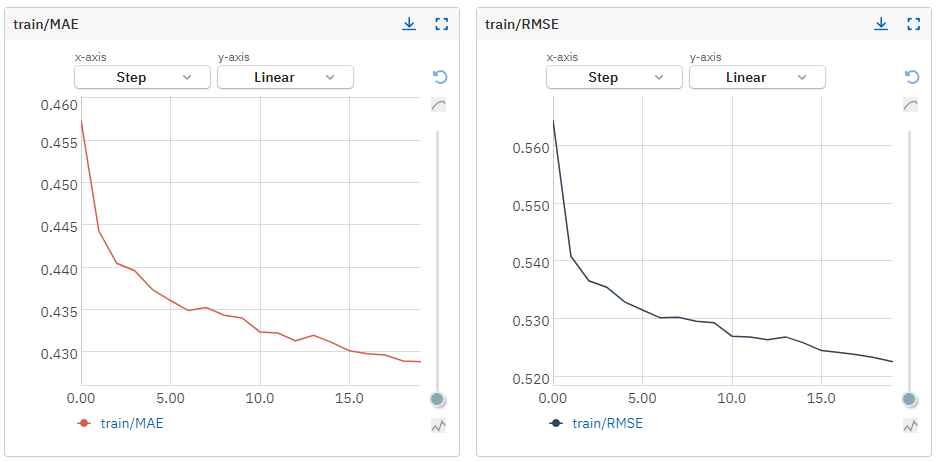
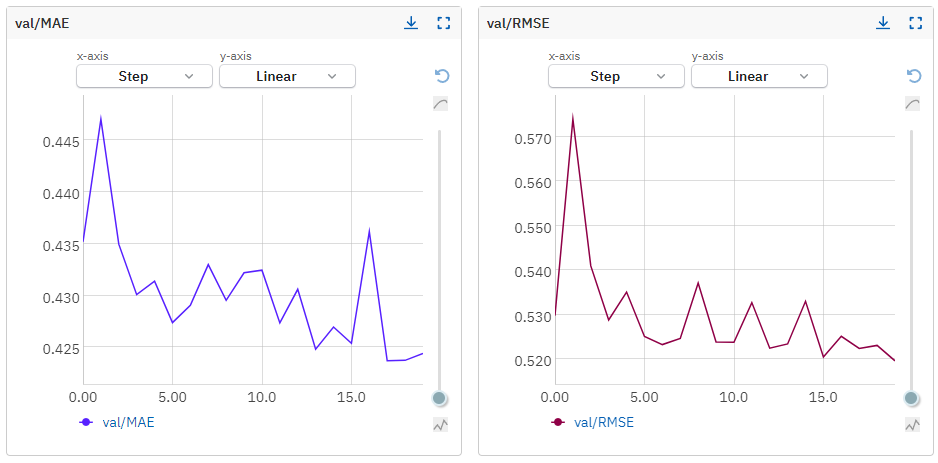

### **Results & Experiments**
1. with the base final hyperparameters, batchsize=64,lr=0.0001,epochs = 10
   - Small improvment but not significant( ~0.1 less on all metrics).
   - validation going up and down, training deacreses in a stable way.
   - there is a downward trend though, more epochs needed to understand
2. batchsize=64,lr=0.0001,epochs = 20
   - there is still a trend downward, but validaion does not improve.
3. batchsize=32,lr=0.0002,epochs = 20
   - all metrics increased by about 0.2.
   - validation is more stable, but still does not improve
   
EX.16 had the best metrics(DLWOR-60)

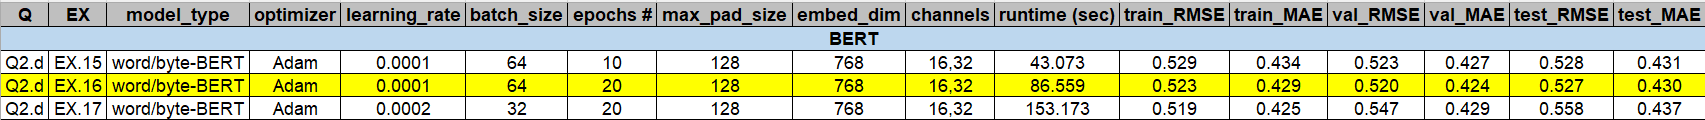

## **Table of all experiments**
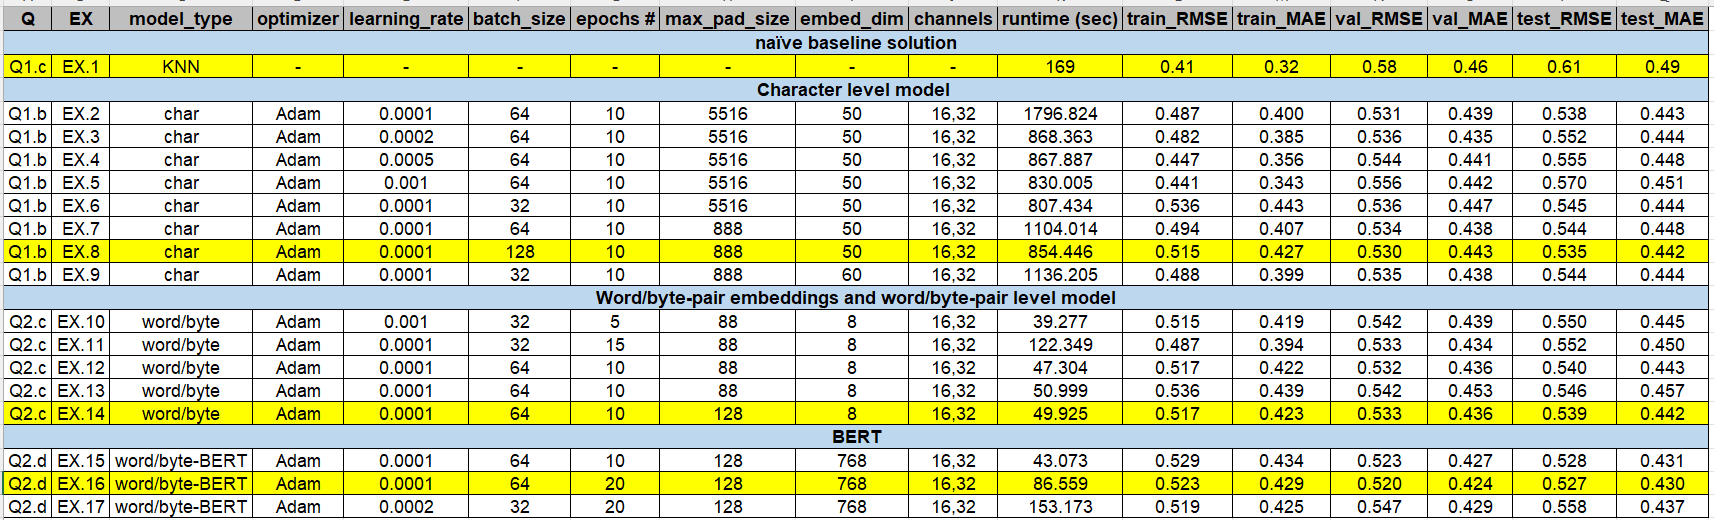